# Pi Robot Exploration

## Setup

In [1]:
import random
from tqdm import tqdm
import numpy as np
import math
import os

%matplotlib inline
from matplotlib import pyplot as plt

import magnum as mn
from PIL import Image

import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut

def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)

### Actual PiCar Stats
- Width: 5", 0.127m
- Length: 7", 0.178
- Height: 4", 0.1m
- Camera: 3", 0.076m

In [17]:
sim_cfg = habitat_sim.SimulatorConfiguration()
sim_cfg.scene_id = './data//versioned_data/replica_cad_baked_lighting_1.0/remake_v0_v3_sc4_staging_05.glb'
sim_cfg.enable_physics = True
sim_cfg.allow_sliding = False

picam = habitat_sim.CameraSensorSpec()
picam.uuid = "color_sensor"
picam.sensor_type = habitat_sim.SensorType.COLOR
# TODO: Noise model?
picam.resolution = [720, 1280]
picam.hfov = 62.2 # https://elinux.org/Rpi_Camera_Module#Technical_Parameters_.28v.2_board.29
picam.position = [0.0, 0.076, 0.0] # TODO: maybe change y position since it's not in the center?

# agent
agent_cfg = habitat_sim.agent.AgentConfiguration()
agent_cfg.sensor_specifications = [picam]
agent_cfg.height = 0.1
agent_cfg.mass = 0.5
agent_cfg.linear_acceleration = 1.4


picar = habitat_sim.Configuration(sim_cfg, [agent_cfg])

In [18]:
try:  # Needed to handle out of order cell run in Colab
    sim.close()
except NameError:
    pass
sim = habitat_sim.Simulator(picar)

W0120 09:36:55.514781 84473 simulator.py:223] Could not find navmesh ./data//versioned_data/replica_cad_baked_lighting_1.0/remake_v0_v3_sc4_staging_05.navmesh, no collision checking will be done
I0120 09:36:55.349272 85869952 BulletPhysicsManager.cpp:35] Deconstructing BulletPhysicsManager
I0120 09:36:55.349989 85869952 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I0120 09:36:55.350004 85869952 SemanticScene.h:43] Deconstructing SemanticScene
I0120 09:36:55.350009 85869952 SceneManager.h:25] Deconstructing SceneManager
I0120 09:36:55.350014 85869952 SceneGraph.h:25] Deconstructing SceneGraph
I0120 09:36:55.350271 85869952 Sensor.cpp:69] Deconstructing Sensor
I0120 09:36:55.352576 85869952 Renderer.cpp:71] Deconstructing Renderer
I0120 09:36:55.352814 85869952 WindowlessContext.h:17] Deconstructing WindowlessContext
I0120 09:36:55.362716 85869952 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.j

Renderer: Apple M1 by Apple
OpenGL version: 4.1 Metal - 76.1
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


evious active dataset  changed to default successfully.
I0120 09:36:55.363919 85869952 MetadataMediator.cpp:183] ::setCurrPhysicsAttributesHandle : Old physics manager attributes  changed to ./data/default.physics_config.json successfully.
I0120 09:36:55.363925 85869952 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : ./data//versioned_data/replica_cad_baked_lighting_1.0/remake_v0_v3_sc4_staging_05.glb and dataset : default which is currently active dataset.
I0120 09:36:55.402113 85869952 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : ./data//versioned_data/replica_cad_baked_lighting_1.0/remake_v0_v3_sc4_staging_05.glb changed to proposed scene_instance.json filename : ./data//versioned_data/replica_cad_baked_lighting_1.0/remake_v0_v3_sc4_staging_05.scene_instance.json
I0120 09:36:55.402511 85869952 MetadataMediator.cpp:311] ::getSceneAttributesByName : Dataset : default has no preloaded SceneA

In [4]:
# initialize an agent
agent = sim.initialize_agent(0)

# Set agent state
agent_state = habitat_sim.AgentState()
agent_state.position = np.zeros(3)  # in world space
agent.set_state(agent_state)

# Get agent state
agent_state = agent.get_state()
print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

agent_state: position [0. 0. 0.] rotation quaternion(1, 0, 0, 0)


## Test Moving Around

In [5]:
# obtain the default, discrete actions that an agent can perform
# default action space contains 3 actions: move_forward, turn_left, and turn_right
action_names = list(picar.agents[0].action_space.keys())
print("Discrete action space: ", action_names)


def navigateAndSee(action=""):
    if action in action_names:
        observations = sim.step(action)
        print("action: ", action)
        if display:
            display_sample(observations["color_sensor"])

Discrete action space:  ['move_forward', 'turn_left', 'turn_right']


action:  move_forward


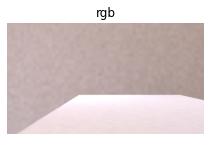

In [6]:
navigateAndSee('move_forward')

## More Sophistication

### NavMesh

In [7]:
navmesh_settings = habitat_sim.NavMeshSettings()

navmesh_settings.set_defaults()
navmesh_settings.cell_size = 0.01 #@param {type:"slider", min:0.01, max:0.2, step:0.01}
#default = 0.05
navmesh_settings.cell_height = 0.01 #@param {type:"slider", min:0.01, max:0.4, step:0.01}
#default = 0.2

#@markdown **Agent parameters**:
navmesh_settings.agent_height = 0.1 #@param {type:"slider", min:0.01, max:3.0, step:0.01}
#default = 1.5
navmesh_settings.agent_radius = 0.1 #@param {type:"slider", min:0.01, max:0.5, step:0.01}
#default = 0.1
navmesh_settings.agent_max_climb = 0.2 #@param {type:"slider", min:0.01, max:0.5, step:0.01}
#default = 0.2
navmesh_settings.agent_max_slope = 45 #@param {type:"slider", min:0, max:85, step:1.0}
# default = 45.0
# fmt: on
navmesh_settings.filter_low_hanging_obstacles = True  # @param {type:"boolean"}
# default = True
navmesh_settings.filter_ledge_spans = True  # @param {type:"boolean"}
# default = True
navmesh_settings.filter_walkable_low_height_spans = True  # @param {type:"boolean"}
# default = True

navmesh_settings.region_min_size = 0 #@param {type:"slider", min:0, max:50, step:1}
#default = 20
navmesh_settings.region_merge_size = 0 #@param {type:"slider", min:0, max:50, step:1}
#default = 20
navmesh_settings.edge_max_len = 0 #@param {type:"slider", min:0, max:50, step:1}
#default = 12.0
navmesh_settings.edge_max_error = 0.1 #@param {type:"slider", min:0, max:5, step:0.1}
#default = 1.3
navmesh_settings.verts_per_poly = 6.0 #@param {type:"slider", min:3, max:6, step:1}
#default = 6.0
navmesh_settings.detail_sample_dist = 6.0 #@param {type:"slider", min:0, max:10.0, step:0.1}
#default = 6.0
navmesh_settings.detail_sample_max_error = 1.0 #@param {type:"slider", min:0, max:10.0, step:0.1}
# default = 1.0
# fmt: on

navmesh_success = sim.recompute_navmesh(
    sim.pathfinder, navmesh_settings, include_static_objects=True
)

if not navmesh_success:
    print("Failed to build the navmesh! Try different parameters?")

I0120 09:35:35.603055 85869952 PathFinder.cpp:382] Building navmesh with 718x304 cells
I0120 09:35:35.842408 85869952 PathFinder.cpp:652] Created navmesh with 1173 vertices 807 polygons
I0120 09:35:35.843698 85869952 Simulator.cpp:798] reconstruct navmesh successful


In [8]:
def random_position():
    agent_state = sim.agents[0].get_state()
    agent_state.position = sim.pathfinder.get_random_navigable_point()
    orientation = random.random() * math.pi * 2.0
    agent_state.rotation = utils.quat_from_magnum(
        mn.Quaternion.rotation(-mn.Rad(orientation), mn.Vector3(0, 1.0, 0))
    )

    sim.agents[0].set_state(agent_state)

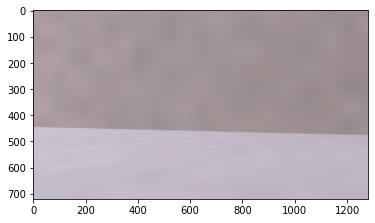

In [9]:
random_position()
plt.imshow(sim.get_sensor_observations()['color_sensor'])

## Continuous Navigation

In [19]:
vel_control = habitat_sim.physics.VelocityControl()
vel_control.controlling_lin_vel = True
vel_control.lin_vel_is_local = True
vel_control.controlling_ang_vel = True
vel_control.ang_vel_is_local = True


agent = sim.agents[0]

ACCEL = 0.1 # m/s^2
MAX_VEL = 1.5 # m/s
target_linear_vel = 0. # m/s

def move_linear(direction):
    global target_linear_vel
    target_linear_vel= float(direction)
    
def turn(direction):
    vel_control.angular_velocity = np.array([0, float(direction), 0])
    
def update_position(time_step):
    current_vel = vel_control.linear_velocity[2]
    
    next_step_vel = None
    if target_linear_vel > current_vel:
        next_step_vel = min(MAX_VEL, current_vel + ACCEL * time_step)
    else: 
        next_step_vel = max(-1 * MAX_VEL, current_vel - ACCEL * time_step)
    vel_control.linear_velocity = np.array([0., 0., next_step_vel])
    
    # TODO: probably just directly integrate acceleration into state??

    # Integrate the velocity and apply the transform.
    # Note: this can be done at a higher frequency for more accuracy
    agent_state = agent.state
    previous_rigid_state = habitat_sim.RigidState(
        utils.quat_to_magnum(agent_state.rotation), agent_state.position
    )

    # manually integrate the rigid state
    target_rigid_state = vel_control.integrate_transform(
        time_step, previous_rigid_state
    )

    # snap rigid state to navmesh and set state to object/agent
    # calls pathfinder.try_step or self.pathfinder.try_step_no_sliding
    end_pos = sim.step_filter(
        previous_rigid_state.translation, target_rigid_state.translation
    )

    # set the computed state
    agent_state.position = end_pos
    agent_state.rotation = utils.quat_from_magnum(
        target_rigid_state.rotation
    )
    agent.set_state(agent_state)

    # Check if a collision occured
    dist_moved_before_filter = (
        target_rigid_state.translation - previous_rigid_state.translation
    ).dot()
    dist_moved_after_filter = (
        end_pos - previous_rigid_state.translation
    ).dot()

    # NB: There are some cases where ||filter_end - end_pos|| > 0 when a
    # collision _didn't_ happen. One such case is going up stairs.  Instead,
    # we check to see if the the amount moved after the application of the filter
    # is _less_ than the amount moved before the application of the filter
    EPS = 1e-5
    collided = (dist_moved_after_filter + EPS) < dist_moved_before_filter

    # run any dynamics simulation
    sim.step_physics(time_step)
    
    return collided

I0120 09:36:59.369735 85869952 Simulator.cpp:54] Deconstructing Simulator


In [22]:
observations = []
random_position()

sim_time = 10
control_frequency = 1  # @param {type:"slider", min:1, max:30, step:1}
frame_skip = 60  # @param {type:"slider", min:1, max:30, step:1}


fps = control_frequency * frame_skip
print("fps = " + str(fps))

time_step = 1.0 / (frame_skip * control_frequency)
print("time_step = " + str(time_step))
movement = 1
for _ in range(int(sim_time * control_frequency)):
    move_linear(movement)
    turn(random.choice([-1,1,0]))

    for _frame in range(frame_skip):
        collided = update_position(time_step)
        observations.append(sim.get_sensor_observations())
        
        if (collided):
            movement = -1 * movement

print("frames = " + str(len(observations)))

fps = 60
time_step = 0.016666666666666666
frames = 600


In [23]:
vut.make_video(observations, 'color_sensor', 'color', './out.mp4', fps=fps)

Encoding the video: ./out.mp4 
